In [ ]:
# based on: 
# https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38

In [2]:
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import os 
import random
import time 
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, plot_confusion_matrix
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D#, GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
#from keras.layers.core import GlobalAveragePooling2D
from keras import backend as K
from keras import regularizers
from keras.models import Model
import keras

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

In [ ]:
# This block is used to load the data into RAM

# list of dirs containing the data - one for the porosity labeled data and one for the no_porosity_labeled data
dirs = ['/media/jan/Volume_big/datasets/Square_data_Gridsize_220_100µm_corrected/3layer/generated_ds/standard/porosity',
        '/media/jan/Volume_big/datasets/Square_data_Gridsize_220_100µm_corrected/3layer/generated_ds/standard/no_porosity']

length = 1869 # number of samples per category 
random_seed = 22 
image_paths = []
show_time = True  # can be toggled to show the time for loading the data into RAM 

if show_time:
    start_time = time.time()

# creating a list with paths of all files in each folder     
for d in dirs: 
    cur_paths = []
    for path in os.listdir(d):
        full_path = os.path.join(d,path)  # adding the full path as the label is stored in the path
        cur_paths.append(full_path)
    
    # randomly shuffling the created list and cutting it to the desired length
    # added to the code for being able to deal with non pre-balanced data sets - if folders both have same length nothing happens at this point
    random.seed(random_seed) 
    random.shuffle(cur_paths)
    cur_paths = cur_paths[:length] 
    
    image_paths.append(cur_paths) # appending the cut list to a new list containing all the final paths        

image_paths = [val for sublist in image_paths for val in sublist] # getting the seperate image paths out of the list
random.seed(random_seed)
random.shuffle(image_paths) # randomly shuffling the list containing the final paths

labels = []
data = []
# generating the label from the second last part of path for every element in the list and adding it to labels-list
# loading the np array, resizing and storing it to data-list

for path in image_paths:
    label = path.split(os.path.sep)[-2] # here it is 'porosity' or 'no_porosity' 
    # additionally to the pure label the whole path is stored to make a traceback of model_behaviour possible 
    # the number needs to be changed according to the link to output something like '/porosity/ZP...'
    labels.append([label,path[97:]])
    array = np.load(path)
    # img = Image.fromarray(array)   # could be added if resizing operation was necessary
    # img = img.resize((128, 128), PIL.Image.LANCZOS)
    # array_resized = np.array(img)
    data.append(array)
    
# in case of transfer learning the scaling function of the original network should be used 
data = np.array(data, dtype="float") #/ 255.0 
labels = np.array(labels)

# splitting data and labels in train, valid and test set in ratio (0.75, 0.125, 0.125)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
(validX, testX, validY, testY) = train_test_split(testX, testY, test_size=0.5, random_state=42)

# at this point the lables are an array with entries like ['porosity', '/porosity/ZP3_Slice00690_x:1_y:1.npy']
# the following part splits up the array to generate labels and also a list with the full paths 

trainY_list = []
trainY_path = []
testY_list = []
testY_path = []
validY_list = []
validY_path = []

for row in trainY:
    trainY_list.append(row[0])
    trainY_path.append(row[1]) 
trainY = np.array(trainY_list)
trainY_path = np.array(trainY_path)

for row in testY:
    testY_list.append(row[0])
    testY_path.append(row[1]) 
testY = np.array(testY_list)
testY_path = np.array(testY_path)

for row in validY:
    validY_list.append(row[0])
    validY_path.append(row[1]) 
validY = np.array(validY_list)
validY_path = np.array(validY_path)

# the LabelBinarizer module is used to one hot encode the labels 
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
validY = lb.transform(validY)

# now the Labels are arrays containing either a '0' for 'no_porosity' or a '1' for 'porosity'
if show_time:
    print(time.time()-start_time)
    
# the shapes of the different data sets are printed  
print('shape training dataset: ' + str(trainX.shape))
print('shape validation dataset: ' + str(validX.shape))
print('shape test dataset: ' + str(testX.shape))

In [4]:
# preprocessing the inputs with the keras preprocessing function 
trainX_resnet = preprocess_input(trainX)
validX_resnet = preprocess_input(validX)
testX_resnet = preprocess_input(testX)

In [56]:
# loading the model with the imagenet-weights but without the imagenet-classifier 
resnet = ResNet50(include_top = False, weights = 'imagenet', input_shape = (trainX_resnet[1].shape))

/home/jan/anaconda3/envs/tf-gpu-clone/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [57]:
# lists are created containing the names of different parts of the feature 

layer_name_list_1 = ['bn5c_branch2c', 'res5c_branch2c', 'bn5c_branch2b', 'res5c_branch2b', 'bn5c_branch2a', 'res5c_branch2a',                  
'bn5b_branch2c', 'res5b_branch2c', 'bn5b_branch2b', 'res5b_branch2b', 'bn5b_branch2a', 'res5b_branch2a',
'bn5a_branch2c', 'res5a_branch2c', 'bn5a_branch2b', 'res5a_branch2b', 'bn5a_branch2a', 'res5a_branch2a']
                   

layer_name_list_2 = ['bn5c_branch2c', 'res5c_branch2c', 'bn5c_branch2b', 'res5c_branch2b', 'bn5c_branch2a', 'res5c_branch2a',                  
'bn5b_branch2c', 'res5b_branch2c', 'bn5b_branch2b', 'res5b_branch2b', 'bn5b_branch2a', 'res5b_branch2a',
'bn5a_branch2c', 'res5a_branch2c', 'bn5a_branch2b', 'res5a_branch2b', 'bn5a_branch2a', 'res5a_branch2a',
'bn4f_branch2c', 'res4f_branch2c', 'bn4f_branch2b', 'res4f_branch2b', 'bn4f_branch2a', 'res4f_branch2a', 
'bn4e_branch2c', 'res4e_branch2c', 'bn4e_branch2b', 'res4e_branch2b', 'bn4e_branch2a', 'res4e_branch2a', 
'bn4d_branch2c', 'res4d_branch2c', 'bn4d_branch2b', 'res4d_branch2b', 'bn4d_branch2a', 'res4d_branch2a', 
'bn4c_branch2c', 'res4c_branch2c', 'bn4c_branch2b', 'res4c_branch2b', 'bn4c_branch2a', 'res4c_branch2a',  
'bn4b_branch2c', 'res4b_branch2c', 'bn4b_branch2b', 'res4b_branch2b', 'bn4b_branch2a', 'res4b_branch2a',   
'bn4a_branch2c', 'res4a_branch2c', 'bn4a_branch2b', 'res4a_branch2b', 'bn4a_branch2a', 'res4a_branch2a']   


layer_name_list_3 = ['bn5c_branch2c', 'res5c_branch2c', 'bn5c_branch2b', 'res5c_branch2b', 'bn5c_branch2a', 'res5c_branch2a',                  
'bn5b_branch2c', 'res5b_branch2c', 'bn5b_branch2b', 'res5b_branch2b', 'bn5b_branch2a', 'res5b_branch2a',
'bn5a_branch2c', 'res5a_branch2c', 'bn5a_branch2b', 'res5a_branch2b', 'bn5a_branch2a', 'res5a_branch2a',
'bn4f_branch2c', 'res4f_branch2c', 'bn4f_branch2b', 'res4f_branch2b', 'bn4f_branch2a', 'res4f_branch2a', 
'bn4e_branch2c', 'res4e_branch2c', 'bn4e_branch2b', 'res4e_branch2b', 'bn4e_branch2a', 'res4e_branch2a', 
'bn4d_branch2c', 'res4d_branch2c', 'bn4d_branch2b', 'res4d_branch2b', 'bn4d_branch2a', 'res4d_branch2a', 
'bn4c_branch2c', 'res4c_branch2c', 'bn4c_branch2b', 'res4c_branch2b', 'bn4c_branch2a', 'res4c_branch2a',  
'bn4b_branch2c', 'res4b_branch2c', 'bn4b_branch2b', 'res4b_branch2b', 'bn4b_branch2a', 'res4b_branch2a',   
'bn4a_branch2c', 'res4a_branch2c', 'bn4a_branch2b', 'res4a_branch2b', 'bn4a_branch2a', 'res4a_branch2a',
'bn3d_branch2c', 'res3d_branch2c', 'bn3d_branch2b', 'res3d_branch2b', 'bn3d_branch2a', 'res3d_branch2a',                   
'bn3c_branch2c', 'res3c_branch2c', 'bn3c_branch2b', 'res3c_branch2b', 'bn3c_branch2a', 'res3c_branch2a',                     
'bn3b_branch2c', 'res3b_branch2c', 'bn3b_branch2b', 'res3b_branch2b', 'bn3b_branch2a', 'res3b_branch2a',                     
'bn3a_branch2c', 'res3a_branch2c', 'bn3a_branch2b', 'res3a_branch2b', 'bn3a_branch2a', 'res3a_branch2a',                     
]  

layer_name_list_4 = ['bn5c_branch2c', 'res5c_branch2c', 'bn5c_branch2b', 'res5c_branch2b', 'bn5c_branch2a', 'res5c_branch2a',                  
'bn5b_branch2c', 'res5b_branch2c', 'bn5b_branch2b', 'res5b_branch2b', 'bn5b_branch2a', 'res5b_branch2a',
'bn5a_branch2c', 'res5a_branch2c', 'bn5a_branch2b', 'res5a_branch2b', 'bn5a_branch2a', 'res5a_branch2a',
'bn4f_branch2c', 'res4f_branch2c', 'bn4f_branch2b', 'res4f_branch2b', 'bn4f_branch2a', 'res4f_branch2a', 
'bn4e_branch2c', 'res4e_branch2c', 'bn4e_branch2b', 'res4e_branch2b', 'bn4e_branch2a', 'res4e_branch2a', 
'bn4d_branch2c', 'res4d_branch2c', 'bn4d_branch2b', 'res4d_branch2b', 'bn4d_branch2a', 'res4d_branch2a', 
'bn4c_branch2c', 'res4c_branch2c', 'bn4c_branch2b', 'res4c_branch2b', 'bn4c_branch2a', 'res4c_branch2a',  
'bn4b_branch2c', 'res4b_branch2c', 'bn4b_branch2b', 'res4b_branch2b', 'bn4b_branch2a', 'res4b_branch2a',   
'bn4a_branch2c', 'res4a_branch2c', 'bn4a_branch2b', 'res4a_branch2b', 'bn4a_branch2a', 'res4a_branch2a',
'bn3d_branch2c', 'res3d_branch2c', 'bn3d_branch2b', 'res3d_branch2b', 'bn3d_branch2a', 'res3d_branch2a',                   
'bn3c_branch2c', 'res3c_branch2c', 'bn3c_branch2b', 'res3c_branch2b', 'bn3c_branch2a', 'res3c_branch2a',                     
'bn3b_branch2c', 'res3b_branch2c', 'bn3b_branch2b', 'res3b_branch2b', 'bn3b_branch2a', 'res3b_branch2a',                     
'bn3a_branch2c', 'res3a_branch2c', 'bn3a_branch2b', 'res3a_branch2b', 'bn3a_branch2a', 'res3a_branch2a',                     
'bn2c_branch2c', 'res2c_branch2c', 'bn2c_branch2b', 'res2c_branch2b', 'bn2c_branch2a', 'res2c_branch2a', 
'bn2b_branch2c', 'res2b_branch2c', 'bn2b_branch2b', 'res2b_branch2b', 'bn2b_branch2a', 'res2b_branch2a',
'bn2a_branch2c', 'res2a_branch2c', 'bn2a_branch2b', 'res2a_branch2b', 'bn2a_branch2a', 'res2a_branch2a',                                   
]

# 1. setting the whole network as trainable 
resnet.trainable = True

# 2. looping through the layer names and checking whether the layer name is in the selected list
for layer in resnet.layers:
    # if layer name in list -> layer stays trainable
    if layer.name in layer_name_list_3:
        layer.trainable = True
    # if layer name not in list -> layer is set to not trainable
    else:
        layer.trainable = False

# DataFrame is created to give an overview of the layers and trainablility 
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(100)

,Layer Type,Layer Name,Layer Trainable
75,<keras.layers.normalization.BatchNormalization...,bn3d_branch2b,True
76,<keras.layers.core.Activation object at 0x7f6f...,activation_217,True
77,<keras.layers.convolutional.Conv2D object at 0...,res3d_branch2c,True
78,<keras.layers.normalization.BatchNormalization...,bn3d_branch2c,True
79,<keras.layers.merge.Add object at 0x7f6fbb7260b8>,add_71,True
...,...,...,...
170,<keras.layers.core.Activation object at 0x7f6f...,activation_244,True
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x7f6fb9818a20>,add_80,True


In [36]:
resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 220, 220, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 110, 110, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [58]:
# here the final model is created from the Resnet50 feature exxtractor and a new classifier

output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(resnet.input, output=output)
#for layer in resnet.layers:
#    layer.trainable = False

resnet.summary()

model = Sequential()
model.add(resnet)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 220, 220, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 226, 226, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 110, 110, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 110, 110, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

/home/jan/anaconda3/envs/tf-gpu-clone/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 100352)            23587712  
_________________________________________________________________
dense_13 (Dense)             (None, 128)               12845184  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 36,449,537
Trainable params: 36,386,817
Non-trainable params: 62,720
___________________________________________________________

In [60]:
# Here the number of epochs, the Batchsize, the optimizer and the Data Augmentation steps are defined 
# Finally the model is compiled 

EPOCHS = 50
BS = 32
opt = SGD(lr=0.01, momentum=0.9, decay=0.01, nesterov = True)     #'Adam' # should be the default optimizer with standard setting according to Hands-On-ML
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])
aug = ImageDataGenerator(vertical_flip= True,horizontal_flip=True) # data is randomly flipped horizontally as well as vertically to prevent the NN from learning local dependecies aug = ImageDataGenerator(vertical_flip= True,horizontal_flip=True) # data is randomly flipped horizontally as well as vertically to prevent the NN from learning local dependecies 

In [63]:
# Here the actual training process is started 

# first a file is defined where the model_weights are store
filepath="model_weights/Resnet.best.hdf5"

# the checkpoint saved the model weights whenever the validation loss decreases 
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# EarlyStopping is set up to stop training when validation loss isn't decreasing for a number of epochs defindes by the patience parameter
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# checkpoint and Early stopping are added to the callbacks list 
callbacks_list = [checkpoint,es]

# Thbe model is fit to the training data and validated with the validation data 
J = model.fit_generator(aug.flow(trainX_resnet, trainY, batch_size=BS),validation_data=(validX_resnet, validY), steps_per_epoch=len(trainX) // BS,epochs=EPOCHS,callbacks=callbacks_list)

Epoch 1/50
87/87 [==============================] - 34s 396ms/step - loss: 1.4474 - acc: 0.5140 - val_loss: 0.6940 - val_acc: 0.5161

Epoch 00001: val_acc improved from -inf to 0.51606, saving model to model_weights/Resnet.best.hdf5
Epoch 2/50
87/87 [==============================] - 19s 213ms/step - loss: 1.0364 - acc: 0.5151 - val_loss: 0.6927 - val_acc: 0.5289

Epoch 00002: val_acc improved from 0.51606 to 0.52891, saving model to model_weights/Resnet.best.hdf5
Epoch 3/50
87/87 [==============================] - 19s 215ms/step - loss: 1.1017 - acc: 0.5099 - val_loss: 0.7072 - val_acc: 0.4904

Epoch 00003: val_acc did not improve from 0.52891
Epoch 4/50
87/87 [==============================] - 19s 215ms/step - loss: 1.0463 - acc: 0.5231 - val_loss: 0.7342 - val_acc: 0.4818

Epoch 00004: val_acc did not improve from 0.52891
Epoch 5/50
87/87 [==============================] - 19s 217ms/step - loss: 1.0357 - acc: 0.5178 - val_loss: 0.7133 - val_acc: 0.4775

Epoch 00005: val_acc did not 

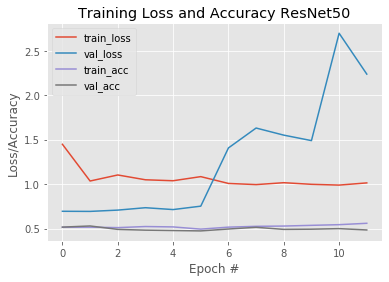

In [64]:
# This block is used for plotting the learning curve

N = np.arange(0,12)#EPOCHS)
plt.style.use("ggplot")
plt.figure
plt.plot(N, J.history["loss"], label="train_loss")
plt.plot(N, J.history["val_loss"], label="val_loss")
plt.plot(N, J.history["acc"], label="train_acc")
plt.plot(N, J.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy ResNet50")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [65]:
# This block is used for creating the confusion matrix and the classification report with the calculated metrics

# As a first step the models best weights are loaded before making the predicitions on the so far held back test set
model.load_weights("model_weights/Resnet.best.hdf5")

model_predictions = model.predict(testX_resnet)
model_predictions =(model_predictions>0.5)

cm = confusion_matrix(testY, model_predictions)
cr = classification_report(testY, model_predictions)


#print(model_name)
print(cm)
print(cr)

[[153  91]
 [147  77]]
              precision    recall  f1-score   support

           0       0.51      0.63      0.56       244
           1       0.46      0.34      0.39       224

    accuracy                           0.49       468
   macro avg       0.48      0.49      0.48       468
weighted avg       0.49      0.49      0.48       468

